In [1]:
import psycopg2
import pandas as pd

con = psycopg2.connect(host='localhost', database='topicos_ii', user='postgres', password='postgres')
cursor = con.cursor()

df = pd.read_sql_query('select * from "database_text"',con=con)

In [2]:
df.head()

,id,classe,narrativa
0,1,religiao,O homem comum entende como sendo a sua religiã...
1,2,religiao,"(...) ...o homem diviniza tudo o que fabrica,e..."
2,3,religiao,O Ateu é Deus\nDeus não existe (...) A salvaçã...
3,4,religiao,O Conflito entre o Conhecimento e a Fé\nDurant...
4,5,religiao,A Religião e o Jornalismo São as Únicas Forças...


In [3]:
from io import StringIO

col = ['classe', 'narrativa']
df = df[col]

df = df[pd.notnull(df['narrativa'])]
df.columns = ['classe', 'narrativa']
df['categoria_id'] = df['classe'].factorize()[0]
categoria_id_df = df[['classe', 'categoria_id']].drop_duplicates().sort_values('categoria_id')
categoria_para_id = dict(categoria_id_df.values)
id_para_categoria = dict(categoria_id_df[['categoria_id', 'classe']].values)
df.head()

,classe,narrativa,categoria_id
0,religiao,O homem comum entende como sendo a sua religiã...,0
1,religiao,"(...) ...o homem diviniza tudo o que fabrica,e...",0
2,religiao,O Ateu é Deus\nDeus não existe (...) A salvaçã...,0
3,religiao,O Conflito entre o Conhecimento e a Fé\nDurant...,0
4,religiao,A Religião e o Jornalismo São as Únicas Forças...,0


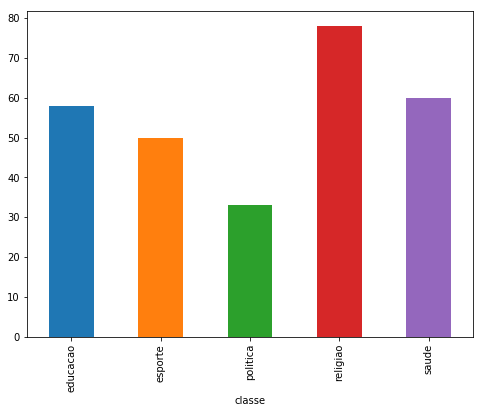

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
df.groupby('classe').narrativa.count().plot.bar(ylim=0)
plt.show()

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.narrativa).toarray()
labels = df.categoria_id
features.shape


(279, 3262)

In [7]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for classe, categoria_id in sorted(categoria_para_id.items()):
  features_chi2 = chi2(features, labels == categoria_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(classe))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'educacao':
  . Most correlated unigrams:
. alunos
. educação
  . Most correlated bigrams:
. os alunos
. da educação
# 'esporte':
  . Most correlated unigrams:
. gol
. jogo
  . Most correlated bigrams:
. dos campeões
. liga dos
# 'politica':
  . Most correlated unigrams:
. bolsonaro
. candidato
  . Most correlated bigrams:
. da república
. jair bolsonaro
# 'religiao':
  . Most correlated unigrams:
. religiões
. religião
  . Most correlated bigrams:
. da religião
. uma religião
# 'saude':
  . Most correlated unigrams:
. pra
. saúde
  . Most correlated bigrams:
. saúde que
. melhor que


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['narrativa'], df['classe'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)



In [9]:
texto = 'A religião é um conjunto de símbolos e rituais que possuem significados amparados pela crença de um grupo de fieis que se identificam com a organização religiosa.'
print(clf.predict(count_vect.transform([texto])))

['religiao']


In [10]:
texto = 'Nascido em 1933, Rubem Alves se dedicou a diversas atividades durante a vida: foi teólogo, psicanalista, educador e escritor. Foi usando principalmente os dois últimos interesses que o mineiro escreveu para a Revista Educação por sete anos, entre 2005 e 2012. Uma falência múltipla de órgãos o levou à morte em 19 de julho de 2014, aos 81 anos.'
print(clf.predict(count_vect.transform([texto])))

['educacao']


In [25]:
texto = 'cuidados com a saúde pública são relagados pra segundo plano'
print(clf.predict(count_vect.transform([texto])))

['saude']
